* DCGAN
* See,
    * https://arxiv.org/abs/1511.06434
    * https://github.com/chainer/chainer/tree/master/examples/dcgan

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [3]:
def add_noise(h, sigma=0.2):
    
    xp = chainer.cuda.get_array_module(h.data)
    if chainer.config.train:
        return h + sigma * xp.random.randn(*h.shape)
    else:
        return h

In [4]:
class Generator(chainer.Chain):

    def __init__(self, n_hidden, bottom_width=4, ch=512, wscale=0.02):
        
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch
        self.bottom_width = bottom_width

        with self.init_scope():
            
            w = chainer.initializers.Normal(wscale)
            self.l0 = L.Linear(self.n_hidden, bottom_width * bottom_width * ch, initialW=w)
            self.dc1 = L.Deconvolution2D(ch, ch // 2, 4, 2, 1, initialW=w)
            self.dc2 = L.Deconvolution2D(ch // 2, ch // 4, 4, 2, 1, initialW=w)
            self.dc3 = L.Deconvolution2D(ch // 4, ch // 8, 4, 2, 1, initialW=w)
            self.dc4 = L.Deconvolution2D(ch // 8, 3, 3, 1, 1, initialW=w)
            self.bn0 = L.BatchNormalization(bottom_width * bottom_width * ch)
            self.bn1 = L.BatchNormalization(ch // 2)
            self.bn2 = L.BatchNormalization(ch // 4)
            self.bn3 = L.BatchNormalization(ch // 8)

    def make_hidden(self, batchsize):
        
        return np.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1)).astype(np.float32)

    def __call__(self, z):
        
        h = F.reshape(F.relu(self.bn0(self.l0(z))), (len(z), self.ch, self.bottom_width, self.bottom_width))
        h = F.relu(self.bn1(self.dc1(h)))
        h = F.relu(self.bn2(self.dc2(h)))
        h = F.relu(self.bn3(self.dc3(h)))
        x = F.sigmoid(self.dc4(h))
        return x

In [5]:
class Discriminator(chainer.Chain):

    def __init__(self, bottom_width=4, ch=512, wscale=0.02):
        
        w = chainer.initializers.Normal(wscale)
        
        super(Discriminator, self).__init__()
        with self.init_scope():
            
            self.c0_0 = L.Convolution2D(3, ch // 8, 3, 1, 1, initialW=w)
            self.c0_1 = L.Convolution2D(ch // 8, ch // 4, 4, 2, 1, initialW=w)
            self.c1_0 = L.Convolution2D(ch // 4, ch // 4, 3, 1, 1, initialW=w)
            self.c1_1 = L.Convolution2D(ch // 4, ch // 2, 4, 2, 1, initialW=w)
            self.c2_0 = L.Convolution2D(ch // 2, ch // 2, 3, 1, 1, initialW=w)
            self.c2_1 = L.Convolution2D(ch // 2, ch // 1, 4, 2, 1, initialW=w)
            self.c3_0 = L.Convolution2D(ch // 1, ch // 1, 3, 1, 1, initialW=w)
            self.l4 = L.Linear(bottom_width * bottom_width * ch, 1, initialW=w)
            self.bn0_1 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_0 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_1 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_0 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_1 = L.BatchNormalization(ch // 1, use_gamma=False)
            self.bn3_0 = L.BatchNormalization(ch // 1, use_gamma=False)

    def __call__(self, x):
        
        h = add_noise(x)
        h = F.leaky_relu(add_noise(self.c0_0(h)))
        h = F.leaky_relu(add_noise(self.bn0_1(self.c0_1(h))))
        h = F.leaky_relu(add_noise(self.bn1_0(self.c1_0(h))))
        h = F.leaky_relu(add_noise(self.bn1_1(self.c1_1(h))))
        h = F.leaky_relu(add_noise(self.bn2_0(self.c2_0(h))))
        h = F.leaky_relu(add_noise(self.bn2_1(self.c2_1(h))))
        h = F.leaky_relu(add_noise(self.bn3_0(self.c3_0(h))))
        return self.l4(h)

In [6]:
class DCGANUpdater(chainer.training.StandardUpdater):

    def __init__(self, *args, **kwargs):
        
        self.gen, self.dis = kwargs.pop('models')
        super(DCGANUpdater, self).__init__(*args, **kwargs)

    def loss_dis(self, dis, y_fake, y_real):
        
        batchsize = len(y_fake)
        L1 = F.sum(F.softplus(-y_real)) / batchsize
        L2 = F.sum(F.softplus(y_fake)) / batchsize
        loss = L1 + L2
        chainer.report({'loss': loss}, dis)
        return loss

    def loss_gen(self, gen, y_fake):
        
        batchsize = len(y_fake)
        loss = F.sum(F.softplus(-y_fake)) / batchsize
        chainer.report({'loss': loss}, gen)
        return loss

    def update_core(self):
        
        gen_optimizer = self.get_optimizer('gen')
        dis_optimizer = self.get_optimizer('dis')

        batch = self.get_iterator('main').next()
        x_real = chainer.Variable(self.converter(batch, self.device)) / 255.
        xp = chainer.cuda.get_array_module(x_real.data)

        gen, dis = self.gen, self.dis
        batchsize = len(batch)

        y_real = dis(x_real)

        z = chainer.Variable(xp.asarray(gen.make_hidden(batchsize)))
        x_fake = gen(z)
        y_fake = dis(x_fake)

        dis_optimizer.update(self.loss_dis, dis, y_fake, y_real)
        gen_optimizer.update(self.loss_gen, gen, y_fake)

In [7]:
gpu = 0

gen = Generator(n_hidden=100)
dis = Discriminator()

if gpu >= 0:
    
    chainer.cuda.get_device(gpu).use()
    gen.to_gpu()
    dis.to_gpu()

opt_gen = chainer.optimizers.Adam()
opt_gen.setup(gen)

opt_dis = chainer.optimizers.Adam()
opt_dis.setup(dis)

In [8]:
epoch_num = 50
batch_size = 50

train, _ = chainer.datasets.get_cifar10(withlabel=False, scale=255.)
train_iter = chainer.iterators.SerialIterator(train, batch_size)

updater = DCGANUpdater(models=(gen, dis), iterator=train_iter, optimizer={'gen': opt_gen, 'dis': opt_dis}, device=gpu)
trainer = chainer.training.Trainer(updater, (epoch_num, 'epoch'), out='result')

#trainer.extend(extensions.snapshot(filename='snapshot_iter_{.updater.iteration}.npz'), trigger=(100, 'iteration'))
#trainer.extend(extensions.snapshot_object(gen, 'gen_iter_{.updater.iteration}.npz'), trigger=(100, 'iteration'))
#trainer.extend(extensions.snapshot_object(dis, 'dis_iter_{.updater.iteration}.npz'), trigger=(100, 'iteration'))
trainer.extend(extensions.LogReport(trigger=(1000, 'iteration')))
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'gen/loss', 'dis/loss', 'elapsed_time']))
#trainer.extend(extensions.ProgressBar(update_interval=10))
#trainer.extend(out_generated_image(gen, dis, 10, 10, args.seed, args.out), trigger=(100, 'iteration'))
trainer.run()

epoch       iteration   gen/loss    dis/loss    elapsed_time
1           1000        6.23716     0.431667    76.7042       
2           2000        6.95417     0.234659    140.036       
3           3000        7.52417     0.253876    203.491       
4           4000        7.60821     0.278475    266.8         
5           5000        7.04308     0.355634    330.059       
6           6000        7.0129      0.256208    393.122       
7           7000        6.25244     0.328678    456.565       
8           8000        8.33237     0.232609    519.392       
9           9000        7.213       0.322811    581.699       
10          10000       7.00375     0.324928    643.867       
11          11000       7.04743     0.432266    705.604       
12          12000       6.86966     0.361467    767.539       
13          13000       7.26022     0.337045    829.499       
14          14000       7.01117     0.466015    891.167       
15          15000       5.32095     0.450424    953.041  

In [9]:
def out_generated_image(gen, dis, rows, cols):
    
    n_images = rows * cols
    xp = gen.xp
    z = chainer.Variable(xp.asarray(gen.make_hidden(n_images)))

    with chainer.using_config('train', False):
        
        x = gen(z)

    x = chainer.cuda.to_cpu(x.data)

    x = np.asarray(np.clip(x * 255, 0.0, 255.0), dtype=np.uint8)
    _, _, H, W = x.shape
    x = x.reshape((rows, cols, 3, H, W))
    x = x.transpose(0, 3, 1, 4, 2)
    x = x.reshape((rows * H, cols * W, 3))

    img = Image.fromarray(x)
    
    return img

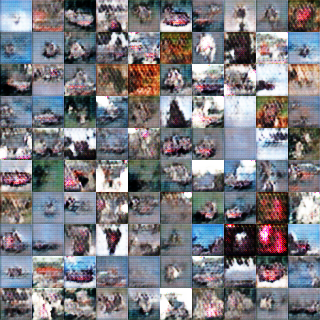

In [11]:
out_generated_image(gen, dis, 10, 10)

In [12]:
!python --version

Python 3.6.3


In [13]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
certifi==2018.4.16
chainer==4.0.0
chainercv==0.10.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
edward==1.3.5
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0.2.0
pexpect==4.5.0
pickleshare==0.7.4
Pillow==5.1.0
prompt-toolkit==1.0.15
protobuf==3.5.2.post1
ptyprocess==0.5.2
pycurl=

In [14]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [15]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
